In [1]:
import tensorflow as tf
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# convert the image into the numerical data
import matplotlib.image as mpimg
import pathlib

## 2022.06.22 Convolution NN Part 1
- Purpose: camera or object detection and so on...
- Data Flow: https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05
  - one filter only have 1 bias in the convolution layer
  - and the number of filters will become the depth of output shape

### Binary Image Classification
- convolution layer: the place to extract and learn the pattern
  - kernal size: the size of filter window
- hidden activation:  add non-linearity to the learned features
- pooling layer: reduce the dimensionality of learned pattern
  - reduce overfitting and computation
  - no activation function
  - learn the most importantt feature from the output that generated by Convolution layer
- flatten layer:
- full connected layer: Further refine the learned patterns

### Food Vision - Inspect the Data
- the original data set is coming from this: https://www.kaggle.com/datasets/dansbecker/food-101
- but we are just using https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 
  - which is coming from food 101 but only contains 2 classes of images 

In [2]:
# download the food vision dataset but only contain two classes of data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_red = zipfile.ZipFile("pizza_steak.zip")
zip_red.extractall()
zip_red.close()

--2022-07-26 13:05:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 172.217.204.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   143MB/s    in 0.7s    

2022-07-26 13:05:39 (143 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [3]:
# Inspect the data - total 2000 images. 1000 for pizza, 1000 for steak
import os
for dirpath,dirnames,filenames in os.walk("pizza_steak"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in the {dirpath}")

there are 2 directories and 0 images in the pizza_steak
there are 2 directories and 0 images in the pizza_steak/train
there are 0 directories and 750 images in the pizza_steak/train/pizza
there are 0 directories and 750 images in the pizza_steak/train/steak
there are 2 directories and 0 images in the pizza_steak/test
there are 0 directories and 250 images in the pizza_steak/test/pizza
there are 0 directories and 250 images in the pizza_steak/test/steak


In [ ]:
len(os.listdir("pizza_steak/train/pizza")) # 750
len(os.listdir("pizza_steak/train/steak")) # 750

750

In [4]:
# check the categories of dataset
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['pizza' 'steak']


### Food Vision - Feature Eng Images
- from tensorflow.keras.preprocessing.images import ImageDataGenerator
  - reshape
  - scale/normalize
  - batches
  - automatically create labels

In [5]:
# random pickup a image and check
import pathlib
import random

def view_random_image(target_dir,target_class):
  target_folder = target_dir + "/" + target_class
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)

  # convert the image to numerical data
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape:{img.shape}")

  return img

['1289139.jpg']
Image shape:(512, 512, 3)


<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[156, 135, 106],
        [154, 133, 104],
        [155, 131, 103],
        ...,
        [229, 215, 152],
        [226, 215, 151],
        [224, 213, 149]],

       [[159, 138, 109],
        [158, 137, 108],
        [159, 138, 107],
        ...,
        [229, 215, 150],
        [228, 214, 151],
        [226, 212, 149]],

       [[155, 134, 103],
        [156, 135, 104],
        [156, 135, 104],
        ...,
        [233, 219, 154],
        [232, 218, 153],
        [231, 217, 152]],

       ...,

       [[171, 104,  85],
        [171, 105,  83],
        [167, 103,  76],
        ...,
        [247, 229, 205],
        [255, 250, 227],
        [255, 252, 228]],

       [[171,  98,  91],
        [174, 104,  94],
        [174, 105,  90],
        ...,
        [204, 180, 156],
        [236, 214, 191],
        [244, 224, 200]],

       [[144,  68,  68],
        [154,  80,  77],
        [159,  86,  79],
        ...,
        [159, 128, 10

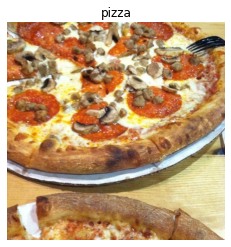

In [6]:
img = view_random_image(target_dir = "pizza_steak/train", target_class="pizza")
tf.constant(img)

### Food Vision - Build EndToEnd model
- the ImageDataGenerator will do the following things automatically
  - reshape to unified weight and height
  - scale/normalize
  - batches
  - auto creating labels

In [7]:
# Data Preprocessing, scaling and fixed the input image shape for each kind of data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)
train_dir = "/content/pizza_steak/train"
test_dir = "/content/pizza_steak/test"

# can do feature engineering when loading the data
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, 
                                               class_mode="binary",
                                               target_size=(224,224),
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32, 
                                               class_mode="binary",
                                               target_size=(224,224),
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# when using the ImageDataGenerator to load the data
# it will automatically create label for us, so no need additional processing to fetch the label data
train_data.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# 47 組 有46組 各32images, 其中有一組28 images
(len(train_data)-1) * 32  + 28

1500

In [15]:
# build model
model = tf.keras.models.Sequential()

# can conv2D -> Conv2D -> Conv2D
model.add(tf.keras.layers.Conv2D(filters=10,
                                 kernel_size=3,
                                 activation="relu",
                                 input_shape=(224,224,3)
                                 ))

model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))

# if no specified stride then stride size will be same as pool size
model.add(tf.keras.layers.MaxPool2D(pool_size=2,
                                    padding='valid'))

model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))


model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])



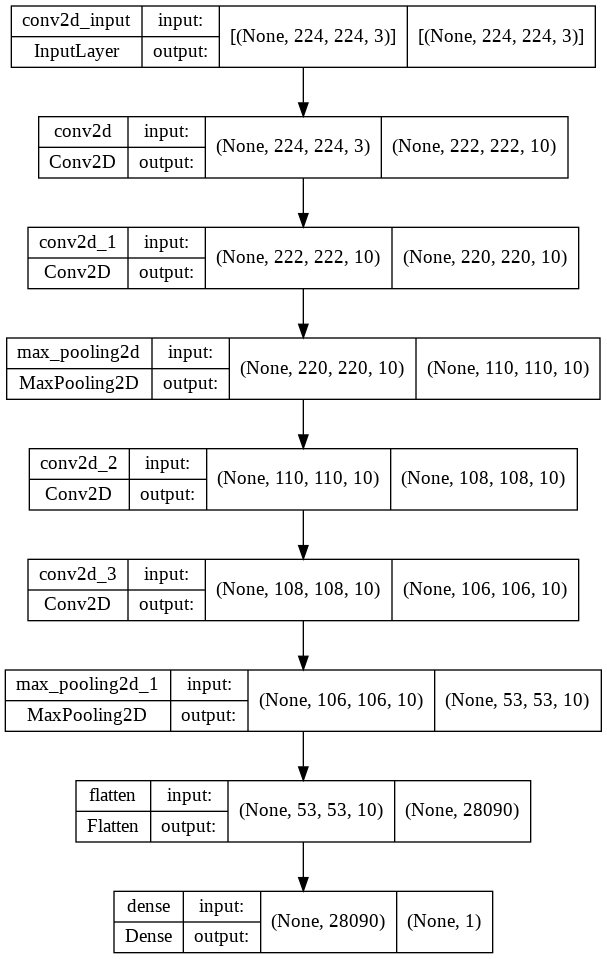

In [16]:
plot_model(model,show_shapes=True)

In [ ]:
history = model.fit(train_data,epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data = valid_data,
                    validation_steps = len(valid_data))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [ ]:
# use non-cnn model to train the model
model_non_cnn = tf.keras.models.Sequential()
model_non_cnn.add(tf.keras.layers.Flatten(input_shape=(224,224,3)))
model_non_cnn.add(tf.keras.layers.Dense(100,activation="relu"))
model_non_cnn.add(tf.keras.layers.Dense(100,activation="relu"))
model_non_cnn.add(tf.keras.layers.Dense(100,activation="relu"))
model_non_cnn.add(tf.keras.layers.Dense(1,activation="sigmoid"))

model_non_cnn.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

histroy_non_cnn = model_non_cnn.fit(train_data,
                                epochs=5,
                                steps_per_epoch = len(train_data),
                                validation_data = valid_data,
                                validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 187ms/step - loss: 2.7532 - accuracy: 0.6453 - val_loss: 0.6603 - val_accuracy: 0.7240
Epoch 2/5
47/47 [==============================] - 8s 178ms/step - loss: 1.5767 - accuracy: 0.6667 - val_loss: 3.8140 - val_accuracy: 0.5260
Epoch 3/5
47/47 [==============================] - 9s 185ms/step - loss: 1.6922 - accuracy: 0.6880 - val_loss: 3.5672 - val_accuracy: 0.5400
Epoch 4/5
47/47 [==============================] - 8s 179ms/step - loss: 1.1066 - accuracy: 0.6967 - val_loss: 0.5194 - val_accuracy: 0.7440
Epoch 5/5
47/47 [==============================] - 8s 178ms/step - loss: 0.9160 - accuracy: 0.7067 - val_loss: 0.6716 - val_accuracy: 0.7740


## 2022.06.23 Convolution NN Part 2

### Breakdown - Data Preparation
- why need batches
  - reduce huge computation in one time like load all data into the memory and break the processor
  - model will learn better than the one using all datasets during trainiing
- preprocessing
  - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

Image shape:(512, 512, 3)
Image shape:(512, 512, 3)


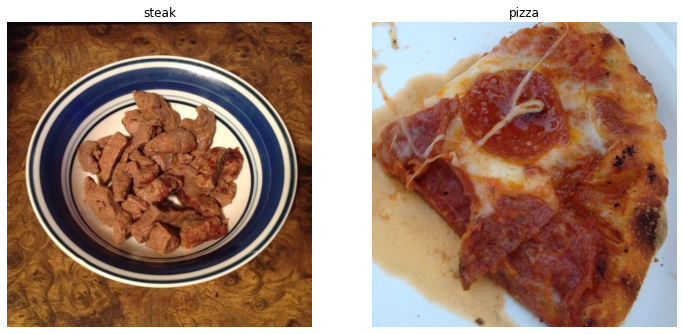

In [ ]:
# Visualize the data
plt.figure(figsize=(12,9))
plt.subplot(1,2,1)
img1 = view_random_image("pizza_steak/train","steak")
plt.subplot(1,2,2)
img2 = view_random_image("pizza_steak/train","pizza")

In [ ]:
# import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Batches the data and Preprocess the data 
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory("pizza_steak/train",
                                           target_size=(224,224),
                                           class_mode="binary", # determine how to generate the output data
                                           batch_size=32,
                                           seed=42,)
# can use class_indices to see the relatioship between numeric class id and actual class label
print(train_data.class_indices)

valid_data = valid_gen.flow_from_directory("pizza_steak/test",
                                           target_size=(224,224),
                                           class_mode="binary",
                                           batch_size=32,
                                           seed=42,)

Found 1500 images belonging to 2 classes.
{'pizza': 0, 'steak': 1}
Found 500 images belonging to 2 classes.


In [ ]:
# how to extract the data froom ImageDataGenerator
images,labels = train_data.next()

 # total 47 batches, and there are 32 sample in one batch
len(images),len(labels),len(train_data)

(32, 32, 47)

In [ ]:
images[:2],images[0].shape

(array([[[[0.42352945, 0.43137258, 0.34509805],
          [0.31764707, 0.3254902 , 0.2392157 ],
          [0.26666668, 0.28235295, 0.18431373],
          ...,
          [0.42352945, 0.34901962, 0.37254903],
          [0.427451  , 0.34901962, 0.39607847],
          [0.45098042, 0.36862746, 0.427451  ]],
 
         [[0.2901961 , 0.30588236, 0.21568629],
          [0.45882356, 0.47450984, 0.37647063],
          [0.2627451 , 0.28627452, 0.18431373],
          ...,
          [0.39607847, 0.34117648, 0.34117648],
          [0.4156863 , 0.36862746, 0.37647063],
          [0.39607847, 0.34901962, 0.3647059 ]],
 
         [[0.37254903, 0.39607847, 0.29411766],
          [0.39607847, 0.41960788, 0.31764707],
          [0.30588236, 0.34117648, 0.23529413],
          ...,
          [0.34509805, 0.3254902 , 0.3019608 ],
          [0.30980393, 0.29803923, 0.27058825],
          [0.3372549 , 0.3254902 , 0.30588236]],
 
         ...,
 
         [[0.5137255 , 0.5019608 , 0.54509807],
          [0.52156

### Breakdown - Basedline Model
- usually in the deep learning model, there are multiple deep learning model, 
- so we can start with the based line mode and search paper with code then tune the model later
- then might happen overfitting but it is ok, can reduce overfitting

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=10,
                                 kernel_size=3,
                                 activation="relu",
                                 input_shape=(224,224,3),
                                 padding="valid",
                                 strides=1))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))

model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))

# maxpooling layer default stride will use pool size if the stride is not specified.
model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation="sigmoid"))


model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,

                    # get len(valid_data)*batch_size(32) to do the validation.
                    validation_steps=len(valid_data), # 拿多少 vallidation-steps 的batches 來做validation
                    epochs=5)

Epoch 1/5
47/47 [==============================] - 9s 188ms/step - loss: 0.6322 - accuracy: 0.6413 - val_loss: 0.5423 - val_accuracy: 0.7040
Epoch 2/5
47/47 [==============================] - 9s 185ms/step - loss: 0.4737 - accuracy: 0.7827 - val_loss: 0.3567 - val_accuracy: 0.8640
Epoch 3/5
47/47 [==============================] - 9s 186ms/step - loss: 0.4225 - accuracy: 0.8140 - val_loss: 0.3314 - val_accuracy: 0.8600
Epoch 4/5
47/47 [==============================] - 9s 188ms/step - loss: 0.3896 - accuracy: 0.8187 - val_loss: 0.3267 - val_accuracy: 0.8740
Epoch 5/5
47/47 [==============================] - 9s 183ms/step - loss: 0.3718 - accuracy: 0.8460 - val_loss: 0.3175 - val_accuracy: 0.8700


### Breakdown - Convolution Layer
- Filters, usually use 10,32,64,128
- Kernel size: 3,5,7
- padding: same or valid
  - augument the input shape by adding surrended 0 value outside
  - same: W/H of output shape will be same as input shape
  - valid: W/H of output shape will be less than input shape
- strides:
  - amount to shift when doing convolution or pooling

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

In [ ]:
def plot_loss_curve(history):
  loss = history.history["loss"] # train loss
  val_loss = history.history["val_loss"] # val loss
  accuracy = history.history["accuracy"] # train accuracy
  val_accuracy = history.history["val_accuracy"] # test accuracy

  epochs = range(len(loss))
  epochs = list(map(lambda x:int(x+1),epochs))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()
  plt.show()

  plt.plot(epochs,accuracy,label="training_acc")
  plt.plot(epochs,val_accuracy,label="validation_acc")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.xticks(epochs)
  plt.legend()

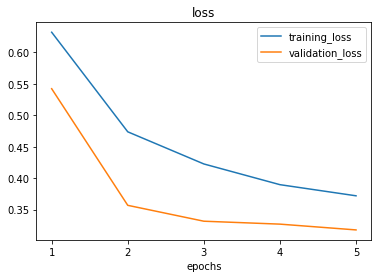

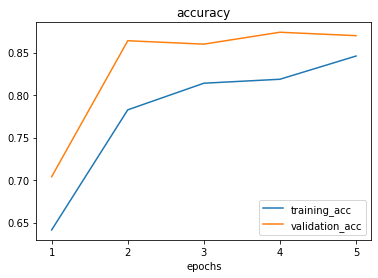

In [ ]:
# overfitting.
plot_loss_curve(history)

### Breakdown - Ways to prevent the Overfitting
- Add Image Augmentation
  - can use ImageDataGenerator to do featture engiineering on the images
  - hope the model can learn more general pattern on the images
- Add Regularization: Maxpolling can prevent the overfitring, reduce multiple trainingable params

In [ ]:
# use ImageDataGenerator to do the data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Batches the data and Preprocess the data 
train_argument_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.3,
                               horizontal_flip=True,
                               )

# non-augmented images
train_gen = ImageDataGenerator(rescale=1./255)
train_data = train_gen.flow_from_directory("pizza_steak/train",
                                           target_size=(224,224),
                                           class_mode="binary", # determine how to generate the output data
                                           batch_size=32,
                                           shuffle=False)
# can use class_indices to see the relatioship between numeric class id and actual class label
print(train_data.class_indices)

# why we don't do the preprocessing or augmentation oon the testing dataset
# because we only apply the same feature engineering rule to the training and testing data set based on what we do
# on the training dataset only.
# 或者是我學習了general pattern, 然後用normal image 去 evaluate, 看狀況是怎麼樣也可以 不一定test data 要做augment
test_gen = ImageDataGenerator(rescale=1./255)
test_data = valid_gen.flow_from_directory("pizza_steak/test",
                                           target_size=(224,224),
                                           class_mode="binary",
                                           batch_size=32,
                                           shuffle=False)

Found 1500 images belonging to 2 classes.
{'pizza': 0, 'steak': 1}
Found 500 images belonging to 2 classes.


### Breakdown - Image Augmentation & Shuffle
- cuz the ImageDataGenerator is a generator, so the data will do preprocessing once starting the training, it won't do preprocessing once it loaded to the code until it is called or get(next) 
- better to do augmentation on training dataset let model can learn more generic pattern
  - not necessary to apply the augmentation on the testinf data set because not meaningful. 
  - what we need to do is to use the model to evaluate or predict incoming images
- and shuffle the data so that the model won't tend to learn a kind of pattern on a specific class

In [ ]:
print("Augmented training data")
train_augment_data = train_argument_gen.flow_from_directory("pizza_steak/train",
                                           target_size=(224,224),
                                           class_mode="binary", # determine how to generate the output data
                                           batch_size=32,
                                           shuffle=True)


Augmented training data
Found 1500 images belonging to 2 classes.


In [ ]:
images,labels = train_data.next()
a_images,a_labels = train_augment_data.next()

(-0.5, 223.5, 223.5, -0.5)

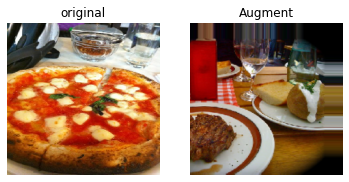

In [ ]:
import random
random_choice = random.randint(0,len(images))
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(images[random_choice])
plt.axis(False)

plt.subplot(1,2,2)
plt.title("Augment")
plt.imshow(a_images[random_choice])
plt.axis(False)

In [ ]:
model_a = tf.keras.Sequential()
model_a.add(tf.keras.layers.Conv2D(filters=10,
                                 kernel_size=3,
                                 activation="relu",
                                 input_shape=(224,224,3),
                                 padding="valid",
                                 strides=1))
model_a.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))

model_a.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model_a.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model_a.add(tf.keras.layers.Conv2D(10,3,activation="relu"))

# maxpooling layer default stride will use pool size if the stride is not specified.
model_a.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model_a.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model_a.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model_a.add(tf.keras.layers.Flatten())
model_a.add(tf.keras.layers.Dense(1,activation="sigmoid"))


model_a.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



# will do the preprocessinng or augmentation when loading the data to model because it is generator
history_a = model_a.fit(train_augment_data,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,

                    # get len(valid_data)*batch_size(32) to do the validation.
                    validation_steps=len(test_data), # 拿多少 vallidation-steps 的batches 來做validation
                    epochs=5)

Epoch 1/5
47/47 [==============================] - 25s 520ms/step - loss: 0.6748 - accuracy: 0.5773 - val_loss: 0.6010 - val_accuracy: 0.6680
Epoch 2/5
47/47 [==============================] - 22s 467ms/step - loss: 0.5810 - accuracy: 0.6953 - val_loss: 0.4005 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 22s 463ms/step - loss: 0.5227 - accuracy: 0.7493 - val_loss: 0.3888 - val_accuracy: 0.8340
Epoch 4/5
47/47 [==============================] - 22s 461ms/step - loss: 0.4897 - accuracy: 0.7660 - val_loss: 0.3650 - val_accuracy: 0.8480
Epoch 5/5
47/47 [==============================] - 22s 463ms/step - loss: 0.4576 - accuracy: 0.7980 - val_loss: 0.3285 - val_accuracy: 0.8520


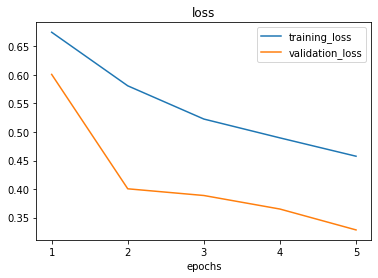

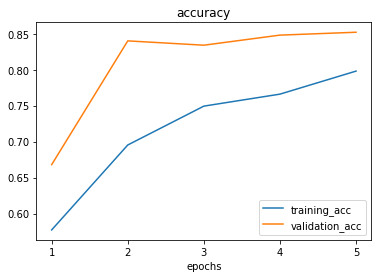

In [ ]:
plot_loss_curve(history_a)

### Breakdown - Improve the Model
- add conv and pool layer, dense layer
- adjust filters/kernal size of conv layer
- adjust activation function
- adjust optimizer and its hyper parameter like lr-rate
- adjust the epochs
- get more data

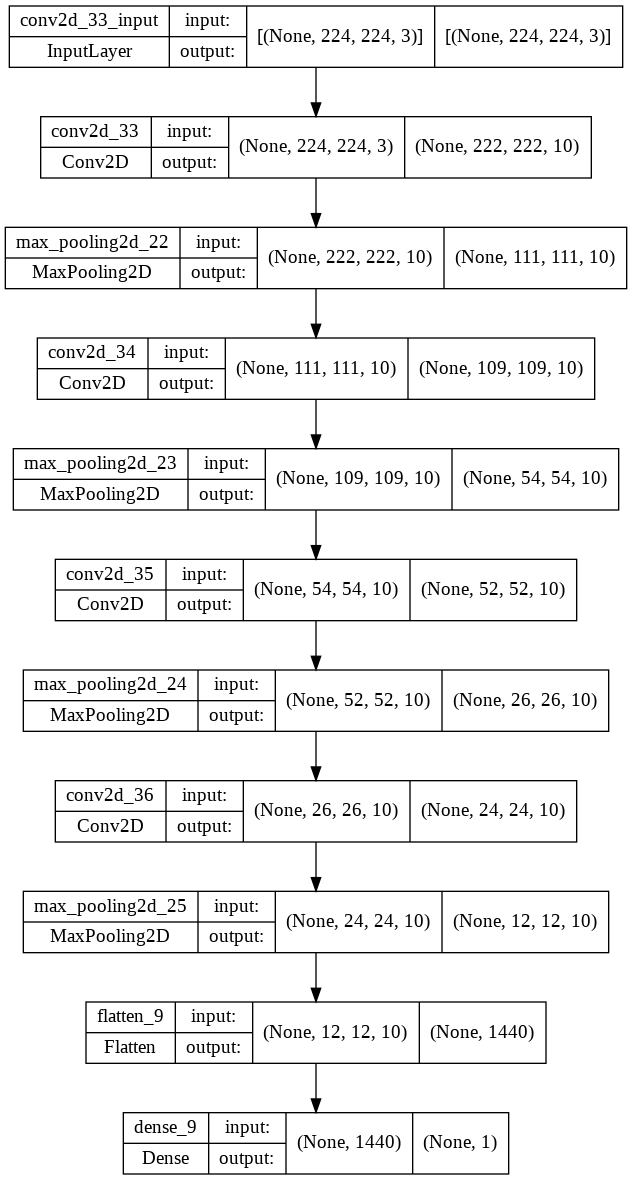

In [ ]:
plot_model(model_a,show_shapes=True)

### Breakdown - Prediction
- do the preprcoessing on the unknown image
  - https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
# Download for file image prediction
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg

--2022-06-22 15:23:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.01s   

2022-06-22 15:23:05 (176 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



(-0.5, 3023.5, 4031.5, -0.5)

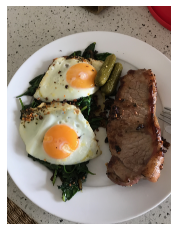

In [ ]:
steak = mpimg.imread("/content/03-steak.jpeg")
plt.imshow(steak)
plt.axis(False)

In [ ]:
# processing the unknown dataset so that it can be fit to the models' acceptable input format

def load_and_prep_image(filename,img_shape=224):
  """
  reads image and turn it into the tensor and reshape it
  """
  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img)

  img = tf.image.resize(img,[img_shape,img_shape])

  img = img * 1./255

  return img

In [ ]:
def pred_and_plot(model,filename,class_names):
  img = load_and_prep_image(filename,img_shape=224)

  pred = model.predict(tf.expand_dims(img,axis=0))

  if len(pred[0]) > 1:
    ind = int(tf.argmax(pred[0]))
  else:
    ind = int(np.round(pred[0]))

  pred_class = class_names[ind]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}, prob.:{pred.ravel()[0]*100:.2f}%")

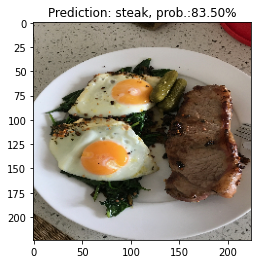

In [ ]:
class_names = list(train_data.class_indices.keys())
pred_and_plot(model_a,"/content/03-steak.jpeg",class_names = class_names)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

--2022-06-22 15:44:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2022-06-22 15:44:24 (185 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



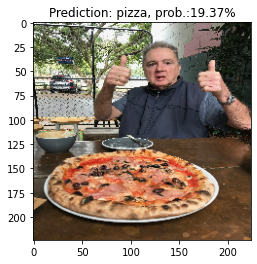

In [ ]:
class_names = list(train_data.class_indices.keys())
pred_and_plot(model_a,"/content/03-pizza-dad.jpeg",class_names = class_names)


## 2022.06.24 - Convolution NN Part 3

### Multiclass class Classification
- Data Preparation
  - training data: 750 * 10 = 7500
  - testing data: 250 * 10 = 2500
- Modeling
  - Create Baseline Model, can use CNN


In [ ]:
import zipfile
link = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-06-23 14:00:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   160MB/s    in 3.1s    

2022-06-23 14:00:09 (160 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
import pathlib
for dirpath,directory,files in os.walk("./10_food_classes_all_data/train"):
  print(f"there are {len(directory)} and {len(files)} in the {dirpath}")

there are 10 and 0 in the ./10_food_classes_all_data/train
there are 0 and 750 in the ./10_food_classes_all_data/train/ice_cream
there are 0 and 750 in the ./10_food_classes_all_data/train/grilled_salmon
there are 0 and 750 in the ./10_food_classes_all_data/train/hamburger
there are 0 and 750 in the ./10_food_classes_all_data/train/pizza
there are 0 and 750 in the ./10_food_classes_all_data/train/chicken_curry
there are 0 and 750 in the ./10_food_classes_all_data/train/steak
there are 0 and 750 in the ./10_food_classes_all_data/train/chicken_wings
there are 0 and 750 in the ./10_food_classes_all_data/train/sushi
there are 0 and 750 in the ./10_food_classes_all_data/train/ramen
there are 0 and 750 in the ./10_food_classes_all_data/train/fried_rice


['ice_cream', 'grilled_salmon', 'hamburger', 'pizza', 'chicken_curry', 'steak', 'chicken_wings', 'sushi', 'ramen', 'fried_rice'] 10
['3333735.jpg']
Image shape:(512, 384, 3)


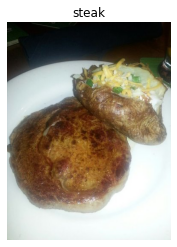

In [ ]:
train_dir = "./10_food_classes_all_data/train"
test_dir = "./10_food_classes_all_data/test"
class_names = os.listdir(train_dir)
print(class_names,len(class_names))
img = view_random_image(train_dir,random.choice(class_names))

In [ ]:
# Preprocessing
train_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               horizontal_flip=True)


train_data = train_gen.flow_from_directory(directory=train_dir,
                                           target_size=(224,224),
                                           class_mode="categorical",
                                           seed=42,
                                           shuffle=True,
                                           batch_size=32)

# test only apply tthe rescaling should be enough
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(directory=test_dir,
                                           target_size=(224,224),
                                           class_mode="categorical", # determine the output layer of shape
                                           seed=42,
                                           shuffle=True,
                                           batch_size=32)                           

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
len(train_data),len(test_data)

(235, 79)

In [ ]:
images,labels = train_data.next()
class_id_map = list(train_data.class_indices.keys())

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


Text(0.5, 1.0, 'sushi')

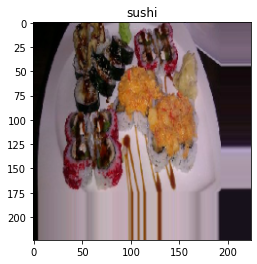

In [ ]:
print(class_id_map)
plt.imshow(images[0])
plt.title(class_id_map[tf.argmax(labels[0])])

### The Ways to reduce overfitting
- Get more data
- Simpilified Data
- Data Augmentation or add regularization like add on maxpooling layer.
- Transfer learning

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=10,
                                 kernel_size=3,
                                 activation="relu",
                                 input_shape=(224,224,3),
                                 padding="valid",
                                 strides=1))
#model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))

#model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
#model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
model.add(tf.keras.layers.Conv2D(10,3,activation="relu"))
# maxpooling layer default stride will use pool size if the stride is not specified.
model.add(tf.keras.layers.MaxPool2D(pool_size=2,padding="valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation="softmax"))


model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,

                    # get len(test_data)*batch_size(32) to do the validation.
                    # to speed up the evaluation process during training, we can use whole test data for evaluation purpose later
                    validation_steps=len(test_data), # 拿多少 vallidation-steps 的batches 來做validation
                    epochs=5,
                    #callbacks=[lr_scheduler]
                    )

Epoch 1/5
235/235 [==============================] - 113s 478ms/step - loss: 2.5791 - accuracy: 0.0933 - val_loss: 2.3034 - val_accuracy: 0.1000
Epoch 2/5
214/235 [==========================>...] - ETA: 8s - loss: 2.3039 - accuracy: 0.1000

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 12s 147ms/step - loss: 1.7981 - accuracy: 0.3744


[1.7980986833572388, 0.37439998984336853]

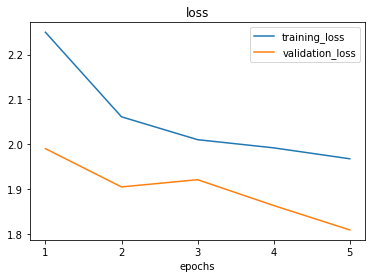

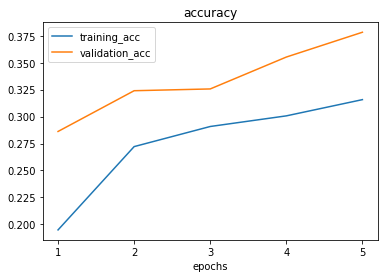

In [ ]:
plot_loss_curve(history=history)

In [ ]:
# clone model, only clonne the structure, won't clone weights and bias those traininable params
model_b = tf.keras.models.clone_model(model)

In [ ]:
# prediction, download the unknown-label dataset
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

--2022-06-23 15:07:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg’

03-hamburger.jpeg   100%[===================>]   3.40M  --.-KB/s    in 0.05s   

2022-06-23 15:07:42 (65.1 MB/s) - ‘03-hamburger.jpeg’ saved [3564285/3564285]



In [ ]:
## prediction

def pred_and_plot(model,filename,class_names,img_shape=224):

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img,[img_shape,img_shape])
  img = img*1./255

  pred = model.predict(tf.expand_dims(img,axis=0))
  ind = int(tf.argmax(pred,axis=1).numpy())
  pred_class = class_names[ind]
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}, prob.:{pred[0,ind]*100:.2f}%")

['ice_cream', 'grilled_salmon', 'hamburger', 'pizza', 'chicken_curry', 'steak', 'chicken_wings', 'sushi', 'ramen', 'fried_rice']


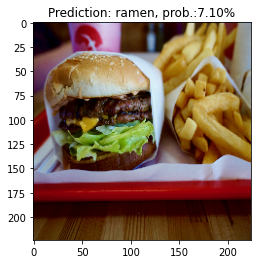

In [ ]:
print(class_names)

pred_and_plot(model,"./03-hamburger.jpeg",class_names=class_names)

### Save and Load Model

In [ ]:
# save model
model.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


In [ ]:
loaded_model = tf.keras.models.load_model("./saved_trained_model")

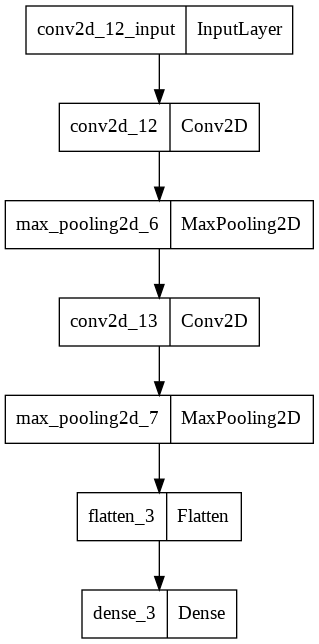

In [ ]:
plot_model(model)

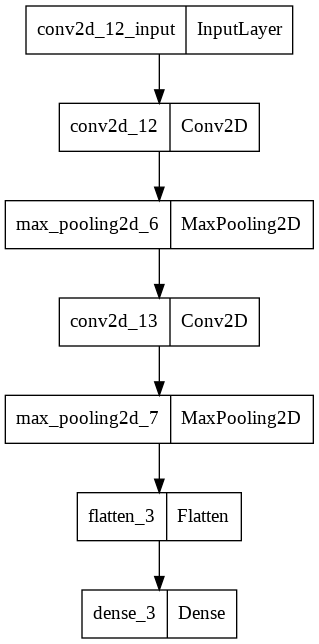

In [ ]:
plot_model(loaded_model)

In [ ]:
  model.evaluate(test_data)

79/79 [==============================] - 17s 216ms/step - loss: 1.8118 - accuracy: 0.3784


[1.811769962310791, 0.3783999979496002]

In [ ]:
loaded_model.evaluate(test_data)

79/79 [==============================] - 11s 135ms/step - loss: 1.8118 - accuracy: 0.3784


[1.811769723892212, 0.3783999979496002]

### AlexNet Model

In [ ]:
from tensorflow.keras import layers

In [ ]:
model_n = tf.keras.models.Sequential()
model_n.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(224,224,3)))
model_n.add(layers.Conv2D(96, 11, strides=4, padding='same'))
model_n.add(layers.Lambda(tf.nn.local_response_normalization))
model_n.add(layers.Activation('relu'))
model_n.add(layers.MaxPooling2D(3, strides=2))
model_n.add(layers.Conv2D(256, 5, strides=4, padding='same'))
model_n.add(layers.Lambda(tf.nn.local_response_normalization))
model_n.add(layers.Activation('relu'))
model_n.add(layers.MaxPooling2D(3, strides=2))
model_n.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model_n.add(layers.Activation('relu'))
model_n.add(layers.Conv2D(384, 3, strides=4, padding='same'))
model_n.add(layers.Activation('relu'))
model_n.add(layers.Conv2D(256, 3, strides=4, padding='same'))
model_n.add(layers.Activation('relu'))
model_n.add(layers.Flatten())
model_n.add(layers.Dense(4096, activation='relu'))
model_n.add(layers.Dropout(0.5))
model_n.add(layers.Dense(4096, activation='relu'))
model_n.add(layers.Dropout(0.5))
model_n.add(layers.Dense(10, activation='softmax'))


model_n.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])



history_n = model_n.fit(train_data,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,                
                    # get len(test_data)*batch_size(32) to do the validation.
                    # to speed up the evaluation process during training, we can use whole test data for evaluation purpose later
                    validation_steps=len(test_data), # 拿多少 vallidation-steps 的batches 來做validation
                    epochs=40,
                    #callbacks=[lr_scheduler]
                    )




Epoch 1/40
235/235 [==============================] - 118s 495ms/step - loss: 2.3050 - accuracy: 0.0935 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/40
 15/235 [>.............................] - ETA: 1:36 - loss: 2.3026 - accuracy: 0.0938

KeyboardInterrupt: ignored

In [ ]:
model_n.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 256)         614656    
                                                      

## Review CNN


In [29]:
### Content
import zipfile

link = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import helper_functions as hf

--2022-07-26 13:25:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-26 13:25:33 (82.0 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [24]:
zip_file = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_file.extractall()
zip_file.close()

In [31]:
hf.walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [69]:
train_data_gen = ImageDataGenerator(rescale=1/255.)
                                    #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    #shear_range=0.2,
                                    #zoom_range=0.2,
                                    #rotation_range=0.2)

test_data_gen = ImageDataGenerator(rescale=1/255.)

train_data = train_data_gen.flow_from_directory(train_dir,
                                                   shuffle=True,
                                                   seed=42,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode="categorical")

test_data = test_data_gen.flow_from_directory(test_dir,
                                                   #shuffle=True,
                                                   #seed=42,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [60]:
image,label = train_data.next()


In [61]:
image.shape

(32, 224, 224, 3)

In [62]:
tf.argmax(label,axis=1)

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 8, 2, 9, 8, 4, 9, 1, 6, 8, 5, 7, 8, 2, 0, 0, 6, 0, 5, 6, 4, 9,
       3, 5, 6, 0, 5, 9, 8, 4, 4, 7])>

In [63]:
list(set(train_data.labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [70]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
     tf.keras.layers.Input(shape=(224,224,3),dtype=tf.float32),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     #tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.MaxPooling2D(pool_size=2),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.MaxPooling2D(pool_size=2),
     tf.keras.layers.Conv2D(10,3,activation="relu"),
     tf.keras.layers.MaxPooling2D(pool_size=2),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(len(list(set(train_data.labels))),activation="softmax")                          
])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [71]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = 5,
                    validation_data = test_data,
                    validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 54s 228ms/step - loss: 2.1127 - accuracy: 0.2296 - val_loss: 1.9424 - val_accuracy: 0.3184
Epoch 2/5
235/235 [==============================] - 43s 184ms/step - loss: 1.8939 - accuracy: 0.3397 - val_loss: 1.8411 - val_accuracy: 0.3624
Epoch 3/5
235/235 [==============================] - 43s 183ms/step - loss: 1.7364 - accuracy: 0.4079 - val_loss: 1.8050 - val_accuracy: 0.3668
Epoch 4/5
235/235 [==============================] - 43s 183ms/step - loss: 1.5491 - accuracy: 0.4775 - val_loss: 1.7945 - val_accuracy: 0.3848
Epoch 5/5
235/235 [==============================] - 43s 183ms/step - loss: 1.3136 - accuracy: 0.5599 - val_loss: 2.0268 - val_accuracy: 0.3668


In [72]:
model.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 2.0268 - accuracy: 0.3668


[2.026779890060425, 0.3668000102043152]

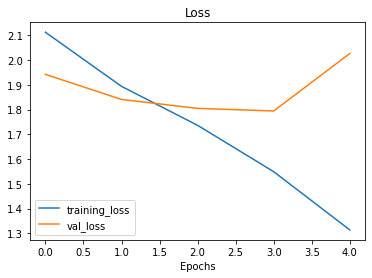

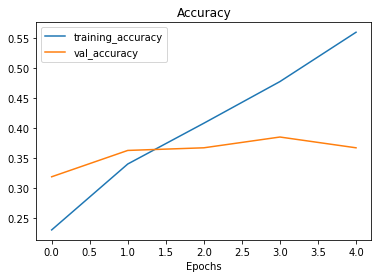

In [74]:
hf.plot_loss_curves(history)

In [76]:
model.save("cnn.h5")

from google.colab import files
files.download('cnn.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 10)      